<a href="https://colab.research.google.com/github/springtimeofyouth/NeuralStyleTransfer/blob/main/Neural_Style_Transfer_Vgg_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [2]:
from google.colab import drive
#content_img= files.upload()
#style_img= files.upload()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
device

device(type='cuda')

# 1. Utility function - to get the Image

In [5]:
def get_image(path,img_transform, size =(300,300)):  #300X300 we can change it if we want
  image = Image.open(path)
  image = image.resize(size, Image.LANCZOS)
  image = img_transform(image).unsqueeze(0)
  #transformations that ill be added to pytorch
  # Basically image dim: 3*H*W -> 1*3*H*W
  return image.to(device)


# 2. Utility function - to get the gram matrix

Consider two vectors(more specifically 2 **flattened feature vectors from a convolutional feature map of depth C**) representing features of the input space, and their **dot product** give us the information about the relation between them. The **lesser the product** the more different the learned features are and **greater the product** , the **more correlated** the features are.

Take all C feature vectors(flattened) from a convolutional feature map of depth C and compute the dot product with every one of them(including with a feature vector itself). The result is the Gram Matrix(of size CxC).



![GramMatrix](https://miro.medium.com/v2/resize:fit:518/format:webp/1*C3fkQanKHMwOi_rf0q0OQQ.png)

In [6]:
def get_gram(mat):
  _, c, h, w = mat.size() # getting batch-size, channels, height, width
  mat = mat.view(c, h * w) #two-dimensional matrix
  mat = torch.mm(mat, mat.t()) # multiplying matrix and its transpose
  return mat

# 3. Utility Function - Denormalized Image

After getting a pytorch tensor, we are de-normalizing it to a numpy array so that we can display it as a numpy image through matplotlib

In [7]:
def denormalized_img(tensor):
  inp = tensor.detach().cpu().squeeze() # squeezing it to remove singleton dimensions
  inp = inp.numpy().transpose((1,2,0)) #C,W,H -> H,W,C
  mean = np.array([0.485,0.456,0.406]) #some standard R,G,B values collected
  std = np.array([0.229,0.224,0.225])  #some standard R,G,B values collected
  inp = inp*std + mean
  inp = np.clip(inp,0,1) #valid pixel intensity range of [0, 1]
  return inp

## Feature Extractor Class
VGG19 is split into two portions:

- vgg19.features, which are all the convolutional and pooling layers
- vgg19.classifier, which are the three linear, classifier layers at the end


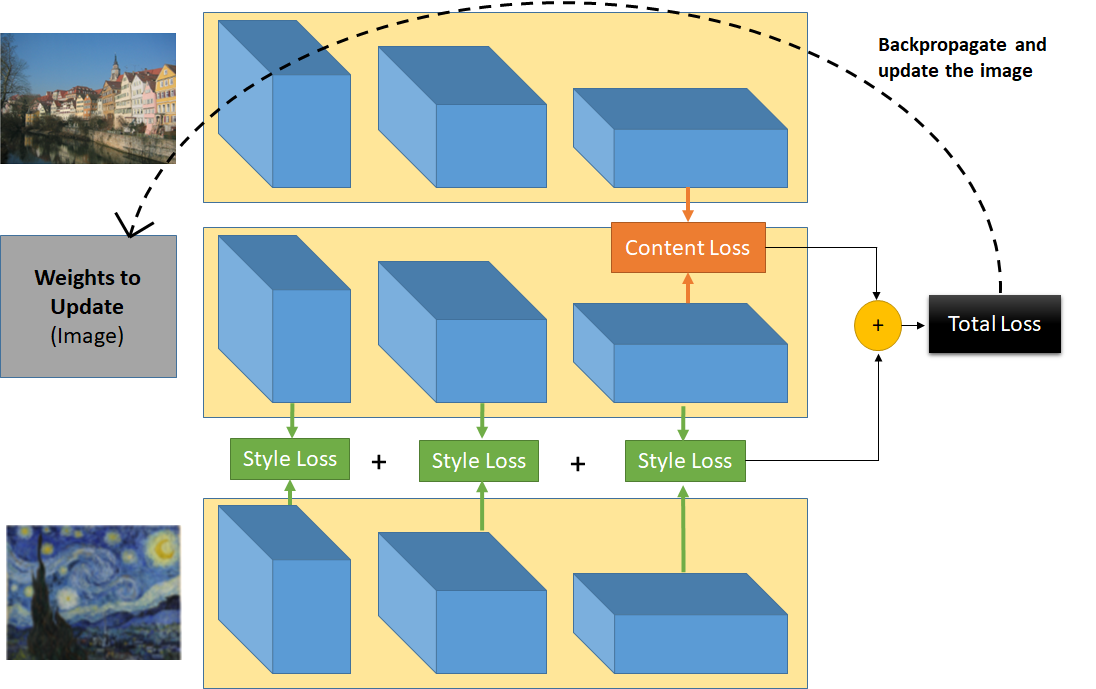

In [8]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()
    self.selected_layers = [0,5,10,19,21] #List of layer indices from the VGG-16 architecture whose features are extracted
    # get the "features" portion of VGG19 (we will not need the "classifier" portion)
    self.vgg = models.vgg19(pretrained = True).features #Loading the VGG-19 model pretrained on ImageNet

  #Iterating through the layers of the VGG-16 model.
  def forward(self, x):
    layer_feats=[]
    for layer_num, layer in self.vgg._modules.items():
      x = layer(x) #Applying each layer to the input
      if int(layer_num) in self.selected_layers:
        layer_feats.append(x)
    return layer_feats


# Taking the Image inputs and Doing the transformation

In [9]:
img_transform= transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean = (0.485,0.456,0.406), std = (0.229,0.224,0.225))])
content_img = get_image('/content/drive/MyDrive/Colab Notebooks/Pytorch/content2.jpg', img_transform) # replace path with content_img if uploading from drive
style_img = get_image('/content/drive/MyDrive/Colab Notebooks/Pytorch/style1.jpg',img_transform) #replace path with style_img if uploading from drive
# generated_img = nn.Parameter(torch.FloatTensor(content_img.size()))
generated_img = content_img.clone()
generated_img.requires_grad=True

optimizer = torch.optim.Adam([generated_img], lr =0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

# freezing the parameters
for p in encoder.parameters():
  p.requires_grad = False

#encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 144MB/s]


# Finally Computing the losses

- Content Loss = Average((content_features - generated_features) $^2$)
- Style Loss = Average((Gram Matrix of generated_features - Gram Matrix of style_features) $^2$) /(channel* height * width)

- Total Loss = Content_weight X Content Loss + Style_Weight X Style Loss

In [10]:
content_weight=1 #content Weight # random weights - may try out a different one
style_weight =100 #Style Weight # random weights - may try out a different one
for epoch in range(500):
  content_features = encoder(content_img)
  style_features = encoder(style_img)
  generated_features = encoder(generated_img)


  #calculating content_loss at the last layer
  content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)

  style_loss=0
  #calculating style_loss
  for gf,sf in zip(generated_features,style_features):
    _, c, h, w= gf.size()
    gram_gf = get_gram(gf)
    gram_sf = get_gram(sf)
    style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w) #normalizing the mean


  loss = content_weight * content_loss + style_weight * style_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch%10 ==0:
    print('Epoch [{}]\tContent Loss: {:.5f}\tStyle Loss: {:.5f}'.format(epoch, content_loss.item(),style_loss.item()))


Epoch [0]	Content Loss: 0.00000	Style Loss: 2920.96265
Epoch [10]	Content Loss: 1.89147	Style Loss: 2463.80811
Epoch [20]	Content Loss: 4.29334	Style Loss: 1926.59949
Epoch [30]	Content Loss: 5.87866	Style Loss: 1517.06128
Epoch [40]	Content Loss: 6.81258	Style Loss: 1258.42444
Epoch [50]	Content Loss: 7.43215	Style Loss: 1073.77576
Epoch [60]	Content Loss: 7.90728	Style Loss: 927.40149
Epoch [70]	Content Loss: 8.29066	Style Loss: 807.85114
Epoch [80]	Content Loss: 8.59787	Style Loss: 709.57581
Epoch [90]	Content Loss: 8.85432	Style Loss: 627.91907
Epoch [100]	Content Loss: 9.07113	Style Loss: 559.62408
Epoch [110]	Content Loss: 9.26031	Style Loss: 502.05856
Epoch [120]	Content Loss: 9.42409	Style Loss: 453.15616
Epoch [130]	Content Loss: 9.57141	Style Loss: 411.12326
Epoch [140]	Content Loss: 9.69994	Style Loss: 374.78049
Epoch [150]	Content Loss: 9.81679	Style Loss: 343.18146
Epoch [160]	Content Loss: 9.91817	Style Loss: 315.51834
Epoch [170]	Content Loss: 10.00749	Style Loss: 291.17

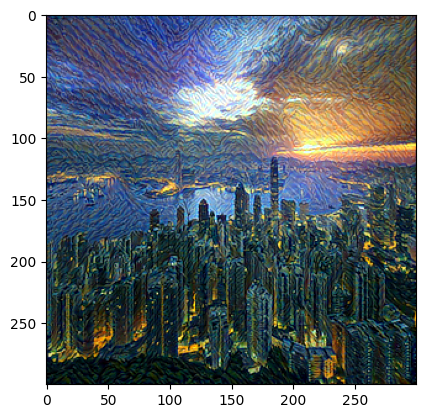

In [11]:
pic = denormalized_img(generated_img)
plt.imshow(pic)

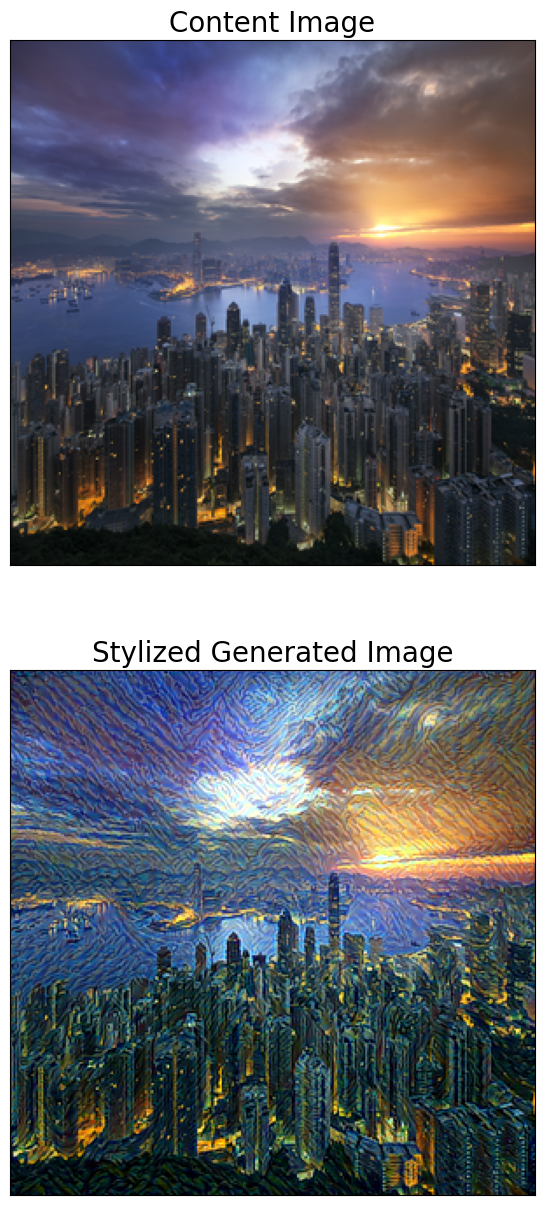

In [12]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(denormalized_img(content_img))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(denormalized_img(generated_img))
ax2.set_title("Stylized Generated Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()